In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
import joblib
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn import metrics
import os
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

### Reading Training data

In [2]:
df1=pd.read_csv("./processed/training/engaged.csv")
df2=pd.read_csv("./processed/training/notEngaged.csv")
dff=pd.read_csv("./TopFeatures.csv")

In [3]:
dft=pd.concat([df1,df2])

In [4]:
feat=dff.to_numpy()
feat=feat.reshape(-1)

In [5]:
print(feat)

[' AU12_c' ' AU04_c' ' AU12_r' ' AU04_r' ' AU05_c' ' AU14_c' ' AU06_c'
 ' AU14_r' ' p_2' ' AU10_c' ' AU06_r' ' AU07_r' ' p_8' ' AU10_r' ' p_0'
 ' p_7' ' p_6' ' p_10' ' p_23' ' AU01_r' ' AU09_r' ' AU17_r' ' AU25_r'
 ' p_12' ' AU05_r' ' AU26_r' ' p_24' ' p_20' ' p_11' ' AU45_r' ' Z_47'
 ' p_5' ' p_30' ' p_9' ' p_26' ' p_16' ' AU02_r' ' p_13' ' p_3' ' p_19'
 ' AU20_r' ' p_27' ' AU15_c' ' AU23_r' ' p_32' ' p_28' ' gaze_angle_y'
 ' p_18' ' p_29' ' p_15']


In [6]:
y_train=dft["Result"]
x_train=dft.drop("Result",axis=1)
x_train=x_train[feat]

In [7]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



### Splitting training and test at ratio 75% to 25%

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train,test_size=0.25)

In [9]:
X_train

,AU12_c,AU04_c,AU12_r,AU04_r,AU05_c,AU14_c,AU06_c,AU14_r,p_2,AU10_c,...,AU20_r,p_27,AU15_c,AU23_r,p_32,p_28,gaze_angle_y,p_18,p_29,p_15
5924,0.0,0.0,0.84,0.00,1.0,0.0,0.0,0.65,4.641,0.0,...,1.06,-0.003,1.0,0.00,0.008,0.023,-0.004,-0.489,0.004,0.685
11937,0.0,0.0,0.22,1.26,0.0,0.0,0.0,0.73,-7.232,0.0,...,0.10,0.034,0.0,0.00,-0.002,0.014,0.218,-0.323,0.040,0.633
9372,0.0,0.0,0.54,0.55,0.0,0.0,0.0,0.03,0.453,0.0,...,0.00,0.058,0.0,0.00,-0.005,0.009,0.297,0.005,-0.024,-0.047
6960,0.0,0.0,0.18,0.48,0.0,0.0,0.0,0.00,-12.962,0.0,...,0.25,-0.009,0.0,0.11,0.006,0.026,0.026,-0.378,0.035,0.892
1876,0.0,0.0,0.00,0.07,0.0,0.0,0.0,0.15,-6.929,0.0,...,0.00,-0.014,0.0,0.00,-0.006,0.005,0.257,0.175,0.015,-0.344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3617,0.0,0.0,0.39,0.00,0.0,0.0,0.0,0.07,-3.821,0.0,...,0.00,-0.033,0.0,0.31,0.001,-0.010,0.509,0.285,-0.011,-0.502
11146,1.0,0.0,0.97,0.81,0.0,0.0,1.0,0.86,5.432,0.0,...,0.11,0.006,0.0,0.29,-0.002,0.030,0.140,-0.590,0.013,0.438
3216,1.0,0.0,0.16,0.46,0.0,1.0,1.0,0.00,-2.581,1.0,...,0.17,0.001,0.0,0.02,0.009,0.024,-0.199,-0.186,-0.002,0.809
8575,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.40,-11.722,0.0,...,0.28,0.036,0.0,0.06,0.003,0.018,0.170,0.041,0.004,-0.044


### Initialize model with optimum parameters

In [10]:
model=tree.DecisionTreeClassifier(class_weight="balanced")

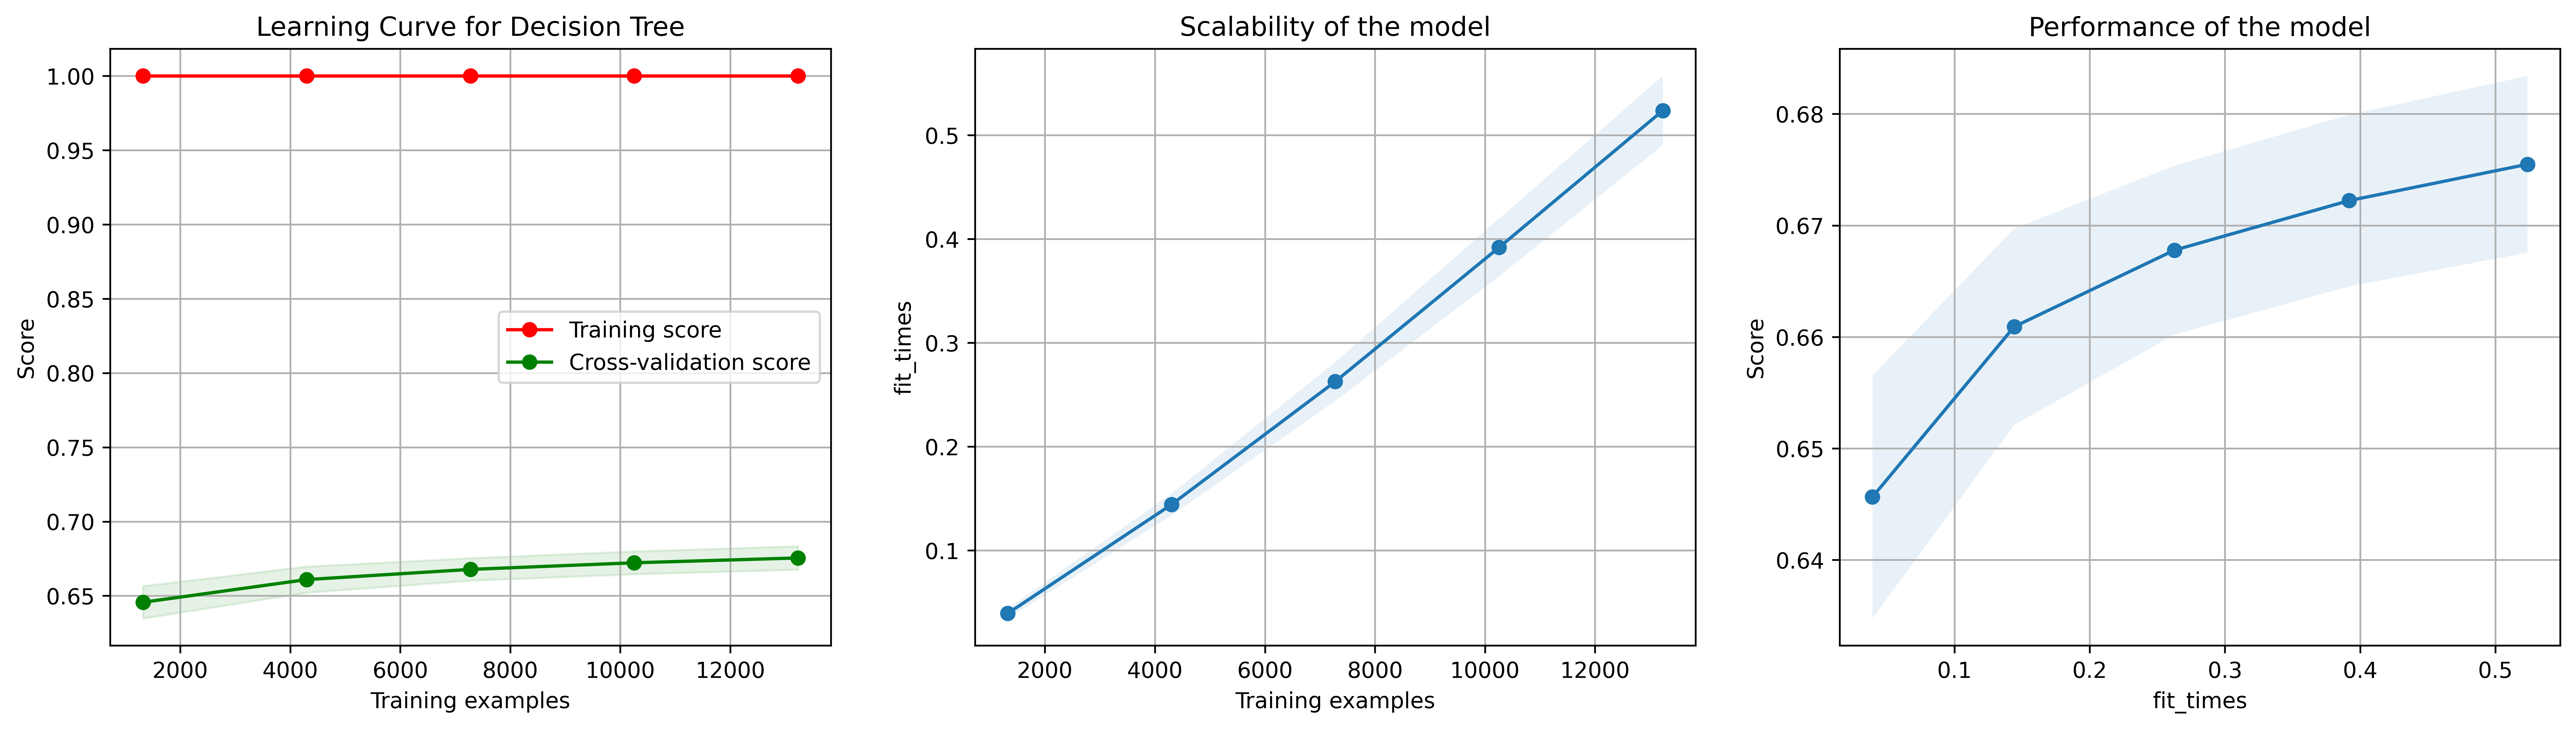

In [11]:
#fig, axes = plt.subplots(3, 1, figsize=(10, 15))


# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)


title = "Learning Curve for Decision Tree"
estimator = model
plot_learning_curve(estimator, title, X_train, Y_train,
                    cv=cv, n_jobs=4)

plt.savefig("dtree.png")

plt.show()
plt.close()
    

### Training of the given model

In [12]:
model = model.fit(X_train, Y_train)

In [13]:
target_names = ['Not Engaged','Engaged']
claf_report=classification_report(Y_test,model.predict(X_test),target_names=target_names,output_dict=True)
print(claf_report)

{'Not Engaged': {'precision': 0.628023352793995, 'recall': 0.6210309278350515, 'f1-score': 0.6245075679037944, 'support': 2425}, 'Engaged': {'precision': 0.7050706033376123, 'recall': 0.7112334088701845, 'f1-score': 0.7081385979049154, 'support': 3089}, 'accuracy': 0.671563293434893, 'macro avg': {'precision': 0.6665469780658037, 'recall': 0.666132168352618, 'f1-score': 0.6663230829043549, 'support': 5514}, 'weighted avg': {'precision': 0.6711860218054629, 'recall': 0.671563293434893, 'f1-score': 0.6713585384648141, 'support': 5514}}


In [14]:
helix=pd.read_csv("./TopFeatures.csv")
h2=pd.read_csv("./heatMaps.csv")
helix['value']=h2
#print(helix)
helix.to_csv("Finalmaps.csv",index=None,header=None)

g1=pd.read_csv("./Finalmaps.csv",index_col=None)
h6=helix['value'].to_numpy()
h6=np.reshape(h6, (50, 1)) # C-like index ordering
#print(h6)

## HeatMap

In [ ]:
plt.figure(figsize=(50,50))

ax=sns.heatmap(h6, annot=True, cmap="coolwarm", yticklabels=helix['0']).set_title('co-relate')
plt.tight_layout()
plt.show()

In [ ]:
sns.heatmap(pd.DataFrame(claf_report).iloc[:-1, :].T, annot=True)

In [ ]:
metrics.plot_confusion_matrix(model, X_test, Y_test, cmap=plt.cm.Blues, display_labels=['Not engaged', 'Engaged'])

In [ ]:
metrics.plot_confusion_matrix(model, X_test, Y_test, cmap=plt.cm.Blues, display_labels=['Not engaged', 'Engaged'], normalize='true')

### Fitting the model on complete data

In [ ]:
model = model.fit(x_train, y_train)

### Saving the Model

In [ ]:
patho=r'./models'
joblib.dump(model, (os.path.join(patho,r''+'model_joblib_decision_tree')))

In [ ]:
plt.close()

In [ ]:
tree.export_graphviz(model,
                     out_file="tree.dot",
                     feature_names = feat, 
                     class_names=["Not Engaged","Engaged"],
                     filled = True)